In [90]:
import numpy as np
import pytreenet as ptn
from copy import deepcopy
np.random.seed(4)

In [91]:
def save_list(list_to_save, filename):
    filename = f"results/{filename}"
    with open(filename, 'w') as file:
        for item in list_to_save:
            file.write(str(item) + '\n')
    print(f"List saved to {filename}")

def load_list(filename):
    filename = f"results/{filename}"
    try:
        with open(filename, 'r') as file:
            return [complex(line.strip()) for line in file.readlines()]
    except FileNotFoundError:
        print(f"File {filename} not found.")
        return []

In [ ]:
d = 9

In [92]:
def product_state(ttn, bond_dim=2 , physical_dim= 2):
    product_state = deepcopy(ttn)
    A = np.asarray(physical_dim*[1/np.sqrt(physical_dim)])
    for node_id in product_state.nodes.keys():
        n = product_state.tensors[node_id].ndim - 1
        tensor = A.reshape((1,) * n + (physical_dim,))
        T = np.pad(tensor, n*((0, bond_dim-1),) + ((0, 0),))
        product_state.tensors[node_id] = T
        product_state.nodes[node_id].link_tensor(T)  
    return product_state

In [93]:
shapes = {
    (0, 0): (2, 2, 2, d),
    (0, 1): (2, 2, d),
    (0, 2): (2, 2, d),
    (1, 0): (2, 2, d),
    (1, 1): (2, d),
    (1, 2): (2, d),
    (2, 0): (2, 2, d),
    (2, 1): (2, 2, 2, d),
    (2, 2): (2, d)
}


sites = {
    (i, j): ptn.random_tensor_node(shapes[(i, j)], identifier=f"Site({i},{j})") for i in range(3) for j in range(3)
}

ttn = ptn.TreeTensorNetworkState()

ttn.add_root(sites[(0, 0)][0], sites[(0, 0)][1])

connections = [
    ((0, 0), (0, 1), 0, 0),
    ((0, 1), (0, 2), 1, 0),
    ((0, 2), (1, 2), 1, 0),
    ((0, 0), (1, 0), 1, 0),
    ((1, 0), (2, 0), 1, 0),
    ((2, 0), (2, 1), 1, 0),
    ((2, 1), (1, 1), 1, 0),
    ((2, 1), (2, 2), 2, 0),

]

for (parent, child, parent_leg, child_leg) in connections:
    parent_id = f"Site({parent[0]},{parent[1]})"
    child_id = f"Site({child[0]},{child[1]})"
    ttn.add_child_to_parent(sites[child][0], sites[child][1], child_leg, parent_id, parent_leg)

ttn = product_state(ttn , bond_dim= 2, physical_dim = d)

nodes = {
    (i, j): (ptn.Node(tensor=ttn.tensors[f"Site({i},{j})"].conj() , identifier=f"Node({i},{j})"), ttn.tensors[f"Site({i},{j})"].conj()) for i in range(3) for j in range(3)
}

ttn.add_child_to_parent(nodes[(0,0)][0], nodes[(0,0)][1], 0, "Site(0,0)", 2)

connections = [
    ((0, 0), (0, 1), 1, 0),
    ((0, 1), (0, 2), 1, 0),
    ((0, 2), (1, 2), 1, 0),
    ((0, 0), (1, 0), 2, 0),
    ((1, 0), (2, 0), 1, 0),
    ((2, 0), (2, 1), 1, 0),
    ((2, 1), (1, 1), 1, 0),
    ((2, 1), (2, 2), 2, 0),
]

for (parent, child, parent_leg, child_leg) in connections:
    parent_id = f"Node({parent[0]},{parent[1]})"
    child_id = f"Node({child[0]},{child[1]})"
    ttn.add_child_to_parent(nodes[child][0], nodes[child][1], child_leg, parent_id, parent_leg)


In [94]:
def normalize_ttn_lindblad(ttn):
    ttn_normalized = ptn.copy_object(ttn, deep = True)
    I = ptn.TTNO.Identity(ttn_normalized)
    for node_id in list(ttn_normalized.nodes.keys()):
        norm = ttn_normalized.operator_expectation_value_Lindblad(I)
        ttn_normalized.tensors[node_id] /= np.sqrt(norm)
    return ttn_normalized
#ttn = normalize_ttn_lindblad(ttn)
#ttn = normalize_ttn_lindblad(ttn)

In [95]:
def Liouville(t, U, J, L, Lx, Ly, d):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators(d)
    
    conversion_dict = {
        "b^dagger": creation_op,
        "b": annihilation_op,
        f"I{d}": np.eye(d)
    }
    
    conversion_dict.update({
        "it * b^dagger": t*1j * creation_op,
        "it * b": t*1j * annihilation_op,
        "-iU * n * (n - 1)": -U*1j * number_op @ (number_op - np.eye(d))
    })
    
    terms = []
    
    # Hopping terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            
            # Horizontal connections
            if x < Lx - 1:
                right_neighbor = f"Site({x+1},{y})"
                terms.append(ptn.TensorProduct({current_site: "it * b^dagger", right_neighbor: "b"}))
                terms.append(ptn.TensorProduct({current_site: "it * b", right_neighbor: "b^dagger"}))
            
            # Vertical connections
            if y < Ly - 1:
                up_neighbor = f"Site({x},{y+1})"
                terms.append(ptn.TensorProduct({current_site: "it * b^dagger", up_neighbor: "b"}))
                terms.append(ptn.TensorProduct({current_site: "it * b", up_neighbor: "b^dagger"}))
    
    # On-site interaction terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "-iU * n * (n - 1)"}))
    
    H1 = ptn.Hamiltonian(terms, conversion_dict)
    
    conversion_dict = {
        "b^dagger.T": creation_op.T,
        "b.T": annihilation_op.T,
        f"I{d}": np.eye(d)
    }
    
    conversion_dict.update({
        "-it * b^dagger.T": -t*1j * creation_op.T,
        "-it * b.T": -t*1j * annihilation_op.T,
        "iU * n * (n - 1).T": (U*1j * number_op @ (number_op - np.eye(d))).T
    })
    
    terms = []
    
    # Hopping terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Node({x},{y})"
            
            # Horizontal connections
            if x < Lx - 1:
                right_neighbor = f"Node({x+1},{y})"
                terms.append(ptn.TensorProduct({current_site: "-it * b^dagger.T", right_neighbor: "b.T"}))
                terms.append(ptn.TensorProduct({current_site: "-it * b.T", right_neighbor: "b^dagger.T"}))
            
            # Vertical connections
            if y < Ly - 1:
                up_neighbor = f"Node({x},{y+1})"
                terms.append(ptn.TensorProduct({current_site: "-it * b^dagger.T", up_neighbor: "b.T"}))
                terms.append(ptn.TensorProduct({current_site: "-it * b.T", up_neighbor: "b^dagger.T"}))
    
    # On-site interaction terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Node({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "iU * n * (n - 1).T"}))    

    H2 = ptn.Hamiltonian(terms, conversion_dict)
    H1.__add__(H2)

    
    conversion_dict = {
    "L": J*L,
    "L^dagger.T": J*L.conj(),
    "-1/2 (L^dagger @ L) ": -1/2 * J**2 *  L.conj().T @ L,
    "-1/2 (L^dagger @ L).T":-1/2 * J**2 * (L.conj().T @ L).T
    }

    terms = []
    for x in range(Lx):
        for y in range(Ly):
            out_site = f"Node({x},{y})"
            in_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({in_site: "L"}))
            terms.append(ptn.TensorProduct({out_site: "L^dagger.T"}))
            terms.append(ptn.TensorProduct({in_site: "-1/2 (L^dagger @ L) "}))
            terms.append(ptn.TensorProduct({out_site: "-1/2 (L^dagger @ L).T"}))

    H3 = ptn.Hamiltonian(terms, conversion_dict)
    H1.__add__(H3)
    return H1

In [96]:
def Unitary(t, U, Lx, Ly, d):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators(d)
    
    conversion_dict = {
        "b^dagger": creation_op,
        "b": annihilation_op,
        f"I{d}": np.eye(d)
    }
    
    conversion_dict.update({
        "it * b^dagger": t * 1.0j* creation_op,
        "it * b": t* 1.0j * annihilation_op,
        "-iU * n * (n - 1)": -U* 1.0j * number_op @ (number_op - np.eye(d))
    })
    
    terms = []
    
    # Hopping terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            
            # Horizontal connections
            if x < Lx - 1:
                right_neighbor = f"Site({x+1},{y})"
                terms.append(ptn.TensorProduct({current_site: "it * b^dagger", right_neighbor: "b"}))
                terms.append(ptn.TensorProduct({current_site: "it * b", right_neighbor: "b^dagger"}))
            
            # Vertical connections
            if y < Ly - 1:
                up_neighbor = f"Site({x},{y+1})"
                terms.append(ptn.TensorProduct({current_site: "it * b^dagger", up_neighbor: "b"}))
                terms.append(ptn.TensorProduct({current_site: "it * b", up_neighbor: "b^dagger"}))
    
    # On-site interaction terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "-iU * n * (n - 1)"}))
    
    H1 = ptn.Hamiltonian(terms, conversion_dict)
    
    conversion_dict = {
        "b^dagger.T": creation_op.T,
        "b.T": annihilation_op.T,
        f"I{d}": np.eye(d)
    }
    
    conversion_dict.update({
        "-it * b^dagger.T": -t* 1.0j * creation_op.T,
        "-it * b.T": -t* 1.0j * annihilation_op.T,
        "iU * n * (n - 1).T": (U* 1.0j* number_op @ (number_op - np.eye(d))).T
    })
    
    terms = []
    
    # Hopping terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Node({x},{y})"
            
            # Horizontal connections
            if x < Lx - 1:
                right_neighbor = f"Node({x+1},{y})"
                terms.append(ptn.TensorProduct({current_site: "-it * b^dagger.T", right_neighbor: "b.T"}))
                terms.append(ptn.TensorProduct({current_site: "-it * b.T", right_neighbor: "b^dagger.T"}))
            
            # Vertical connections
            if y < Ly - 1:
                up_neighbor = f"Node({x},{y+1})"
                terms.append(ptn.TensorProduct({current_site: "-it * b^dagger.T", up_neighbor: "b.T"}))
                terms.append(ptn.TensorProduct({current_site: "-it * b.T", up_neighbor: "b^dagger.T"}))
    
    # On-site interaction terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Node({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "iU * n * (n - 1).T"}))    

    H2 = ptn.Hamiltonian(terms, conversion_dict)
    H1.__add__(H2)
    return H1

In [121]:
def BoseHubbard_ham(t, U, Lx, Ly, d):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators(d)
    
    conversion_dict = {
        "b^dagger": creation_op,
        "b": annihilation_op,
        f"I{d}": np.eye(d)
    }
    
    conversion_dict.update({
        "-t * b^dagger": -t * creation_op,
        "-t * b": -t * annihilation_op,
        "U * n * (n - 1)": U * number_op @ (number_op - np.eye(d))
    })
    
    terms = []
    
    # Hopping terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            
            # Horizontal connections
            if x < Lx - 1:
                right_neighbor = f"Site({x+1},{y})"
                terms.append(ptn.TensorProduct({current_site: "-t * b^dagger", right_neighbor: "b"}))
                terms.append(ptn.TensorProduct({current_site: "-t * b", right_neighbor: "b^dagger"}))
            
            # Vertical connections
            if y < Ly - 1:
                up_neighbor = f"Site({x},{y+1})"
                terms.append(ptn.TensorProduct({current_site: "-t * b^dagger", up_neighbor: "b"}))
                terms.append(ptn.TensorProduct({current_site: "-t * b", up_neighbor: "b^dagger"}))
    
    # On-site interaction terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "U * n * (n - 1)"}))
    
    return ptn.Hamiltonian(terms, conversion_dict)

def BoseHubbard_ham_tp(t, U, Lx, Ly):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators(d)
    
    conversion_dict = {
        "b^dagger": creation_op,
        "b": annihilation_op,
        f"I{d}": np.eye(d)
    }
    
    conversion_dict.update({
        "-t * b^dagger": -t * creation_op,
        "-t * b": -t * annihilation_op,
        "U * n * (n - 1)": U * number_op @ (number_op - np.eye(d))
    })
    
    terms = []
    
    # Hopping terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            
            # Horizontal connections
            if x < Lx - 1:
                right_neighbor = f"Site({x+1},{y})"
                terms.append(ptn.TensorProduct({current_site:  -t * creation_op, right_neighbor: annihilation_op}))
                terms.append(ptn.TensorProduct({current_site: -t * annihilation_op, right_neighbor: creation_op}))
            
            # Vertical connections
            if y < Ly - 1:
                up_neighbor = f"Site({x},{y+1})"
                terms.append(ptn.TensorProduct({current_site:  -t * creation_op, up_neighbor: annihilation_op}))
                terms.append(ptn.TensorProduct({current_site: -t * annihilation_op, up_neighbor: creation_op}))
    
    # On-site interaction terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: U * number_op @ (number_op - np.eye(d))}))
    
    return terms

In [122]:
def Number_op_total(Lx, Ly, dim=2):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators(dim)
    conversion_dict = {"n": number_op , f"I{dim}": np.eye(dim)}

    terms = []
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "n"}))

    return ptn.Hamiltonian(terms, conversion_dict)    

In [123]:
def exchange_bra_ket_tensors(ttn):
    state = deepcopy(ttn)
    ptn.adjust_bra_to_ket(state)
    for ket_id in list(state.nodes.keys())[:(len(state.nodes.keys())//2)]:
        i, j = ket_id.replace('Site(', '').replace(')', '').split(',')
        bra_id = f"Node({i},{j})"
        T1 = state.tensors[bra_id]
        T2 = state.tensors[ket_id]
        state.tensors[ket_id] = T1
        state.nodes[ket_id].link_tensor(T1)
        state.tensors[bra_id] = T2
        state.nodes[bra_id].link_tensor(T2)
    return state

def substitute_out_or_in_legs_of_ttn_with_identity(state, out_or_in , bond_dim=2):
    ttn = deepcopy(state)
    if out_or_in == "Out":
       for node_id in list(ttn.nodes.keys())[(len(ttn.nodes.keys())//2):]:
        n = ttn.tensors[node_id].ndim - 1
        T = np.reshape(np.array([[1,0]]), (n*(1,) + (2,)))
        T = np.pad(T, n*((0, bond_dim-1),) + ((0, 0),))
        ttn.tensors[node_id] = T
        ttn.nodes[node_id].link_tensor(T)   
    if out_or_in == "In":
        for node_id in list(ttn.nodes.keys())[:len(ttn.nodes.keys())//2]:
            n = ttn.tensors[node_id].ndim
            T = ttn.tensors[node_id]
            T = np.reshape(np.array([[1,0]]), (n*(1,) + (2,)))
            T = np.pad(T, n*((0, bond_dim-1),) + ((0, 0),))
            ttn.tensors[node_id] = T
            ttn.nodes[node_id].link_tensor(T)        
    return ttn


In [124]:
# TTNO : Hamiltonian acting on in_legs
H1 = BoseHubbard_ham(0.4, 0.5, 3, 3, d)
H1 = H1.pad_with_identities(ttn, symbolic= True)
H = ptn.TTNO.from_hamiltonian(H1, ttn)

# TTNO : Liouville operator 
creation_op, annihilation_op, number_op = ptn.bosonic_operators(d)
L = annihilation_op 
J = 0.8
H1 = Liouville(0.4, 0.5, J, L, 3, 3, d)
H1 = H1.pad_with_identities(ttn , symbolic= True)
L_fancy = ptn.TTNO.from_hamiltonian(H1, ttn)

# TTNO : Unitary operator
H1 = Unitary(0.4, 0.5, 3, 3, d)
H1 = H1.pad_with_identities(ttn, symbolic= True)
U = ptn.TTNO.from_hamiltonian(H1, ttn)

I = ptn.TTNO.Identity(ttn)

N1 = Number_op_total(3, 3, d)
N1 = N1.pad_with_identities(ttn, symbolic= True)
N = ptn.TTNO.from_hamiltonian(N1, ttn)

ttn.operator_expectation_value_Lindblad(I) , 
ttn.operator_expectation_value_Lindblad(N)


TypeError: BoseHubbard_ham() missing 1 required positional argument: 'd'

In [ ]:
#ttn = ptn.expand_subspace(ttn, U, 3, 0.001, ptn.SVDParameters(max_bond_dim = 24 , rel_tol= 1e-8 , total_tol = -np.inf)
#                          ,1e-30, ptn.KrylovBasisMode.apply_1st_order_expansion)
#ttn.max_bond_dim()

In [ ]:
# Config : Lindblad = True
# time_evolve with exponent = hamiltonian * time_difference
# evaluate_operator with operator_expectation_value_Lindblad(operator)


tdvp_ex1 = ptn.SecondOrderOneSiteTDVP(initial_state = ttn,
                                     hamiltonian = L_fancy,
                                     time_step_size = 0.01,
                                     final_time = 1,
                                     operators = H,
                                     num_vecs = 3,
                                     tau = 1e-3,
                                     SVDParameters = ptn.SVDParameters(max_bond_dim = 20 , rel_tol= 1e-2 , total_tol = -np.inf),
                                     expansion_steps = 5,
                                     initial_tol= 1e-25,
                                     tol_step= 1,
                                     max_bond= 40,
                                     KrylovBasisMode = ptn.KrylovBasisMode.apply_1st_order_expansion,
                                     config = ptn.TTNTimeEvolutionConfig(record_bond_dim=True,
                                                                         Lindblad = True) )

In [ ]:
v

NameError: name 'v' is not defined

In [ ]:
tdvp_ex1.state.max_bond_dim()

16

In [ ]:
I = ptn.TTNO.Identity(ttn)

In [ ]:
tdvp_ex1.state.operator_expectation_value_Lindblad(I) 

array(1.+0.j)

In [ ]:
tdvp_ex1.evaluate_operator(H)

array(-2.4+0.j)

In [ ]:
tdvp_ex1.run_one_time_step_ex(1,1)

In [ ]:
tdvp_ex1.state = ptn.expand_subspace(tdvp_ex1.state, tdvp_ex1.hamiltonian, 
                                     tdvp_ex1.num_vecs, tdvp_ex1.tau, 
                                     tdvp_ex1.SVDParameters, 1e-20, tdvp_ex1.KrylovBasisMode)

In [ ]:
tdvp_ex1.run_ex(evaluation_time=2)

times = tdvp_ex1.times()
tdvp_results_ex1 = tdvp_ex1.operator_results()[0]

100%|██████████| 101/101 [03:24<00:00,  2.03s/it]


In [ ]:
tdvp_results_ex1

array([-2.4       +0.j        , -2.39271423-0.13796159j,
       -2.37096691-0.27425892j, -2.33514699-0.40717086j,
       -2.28520072-0.53492499j, -2.22251297-0.6560632j ,
       -2.14808151-0.76919061j, -2.06296345-0.87302292j,
       -1.96850688-0.96650083j, -1.86617969-1.04877677j,
       -1.75753067-1.1192249j , -1.6441547 -1.17744823j,
       -1.52765658-1.22327902j, -1.40961584-1.25677323j,
       -1.2915535 -1.27819928j, -1.1749017 -1.28802182j,
       -1.06097714-1.28688101j, -0.95095866-1.27556814j,
       -0.84586987-1.25499856j, -0.74656679-1.22618275j,
       -0.65373079-1.19019656j, -0.56786682-1.14815158j,
       -0.4893065 -1.10116659j, -0.4182159 -1.05034085j,
       -0.3546073 -0.9967301j , -0.29835437-0.94132563j,
       -0.24920996-0.88503725j, -0.20682575-0.82868j   ,
       -0.17077289-0.77296514j, -0.14056291-0.71849506j,
       -0.11566804-0.66576213j, -0.09554032-0.61515098j,
       -0.07962891-0.56694395j, -0.06739519-0.52132894j,
       -0.05832527-0.47840926j,

In [ ]:
save_list(tdvp_results_ex1, "test1")

List saved to results/test1


In [ ]:
q = load_list("unitary-2 min")
q

c:\Users\edpou\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\edpou\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


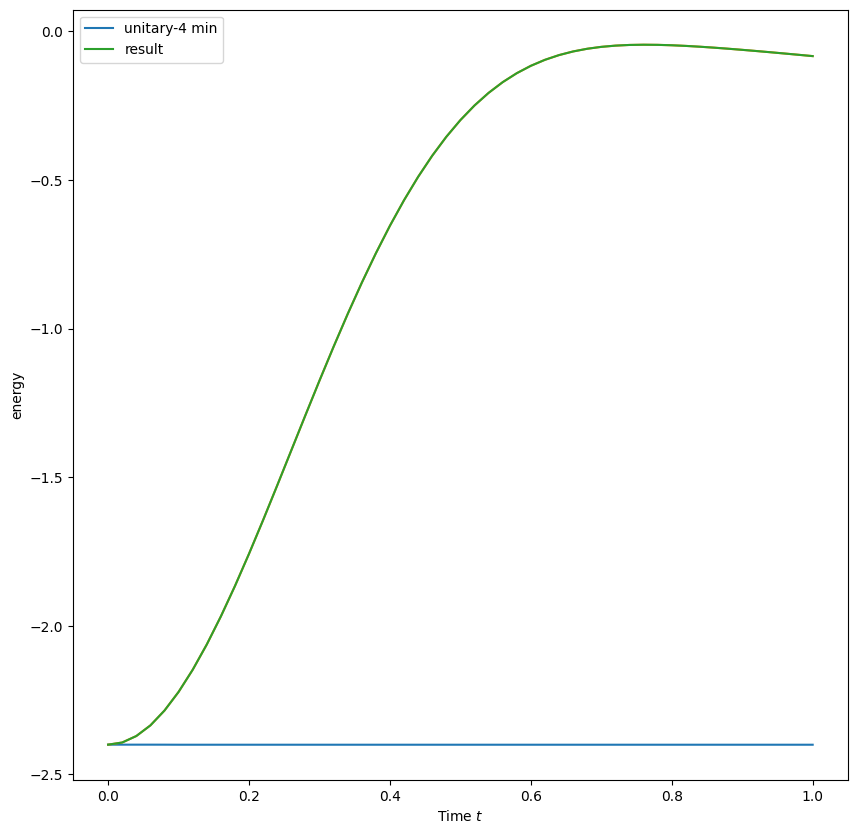

In [ ]:
import matplotlib.pyplot as plt

fig1, axs1 = plt.subplots(1, 1, sharex=True, figsize=(10,10))


axs1.plot(times, load_list("unitary-4 min") , label="unitary-4 min")
axs1.plot(times, load_list("test1") , label="")
#axs1.plot(times, load_list() , label=)
#axs1.plot(times, load_list() , label=)
#axs1.plot(times, load_list() , label=)
#axs1.plot(times, load_list() , label=)
#axs1.plot(times, load_list() , label=)
#axs1.plot(times, load_list() , label=)
#axs1.plot(times, load_list() , label=)


axs1.plot(times, tdvp_results_ex1 , label='result')

axs1.set_xlabel("Time $t$")
axs1.set_ylabel("energy")  
axs1.legend()

List loaded from results/unitary-18 min
List loaded from results/unitary-18 min(2)
List loaded from results/unitary-32 min
List loaded from results/non-unitary-43 min - J=1
List loaded from results/non-unitary-36 min - J=0.8


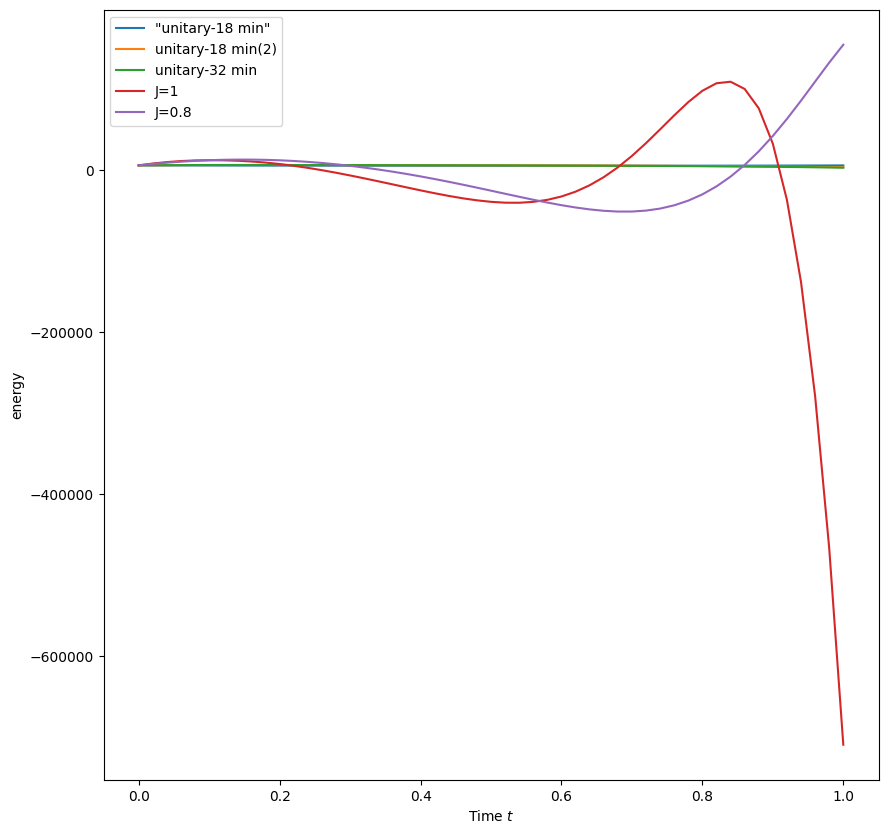

In [ ]:
import matplotlib.pyplot as plt

fig1, axs1 = plt.subplots(1, 1, sharex=True, figsize=(10,10))


axs1.plot(times, load_list("unitary-18 min") , label='"unitary-18 min"')
axs1.plot(times, load_list("unitary-18 min(2)") , label="unitary-18 min(2)")
axs1.plot(times, load_list("unitary-32 min") , label="unitary-32 min")
axs1.plot(times, load_list("non-unitary-43 min - J=1") , label='J=1')
#axs1.plot(times, load_list("non-unitary-53 min - J=10") , label='unitary-32-5')
#axs1.plot(times, load_list("non-unitary-32 min - J=1.5") , label='unitary-32-5')
axs1.plot(times, load_list("non-unitary-36 min - J=0.8") , label='J=0.8')

#axs1.plot(times, tdvp_results_ex1 , label='unitary-32-5')

axs1.set_xlabel("Time $t$")
axs1.set_ylabel("energy")  
axs1.legend()

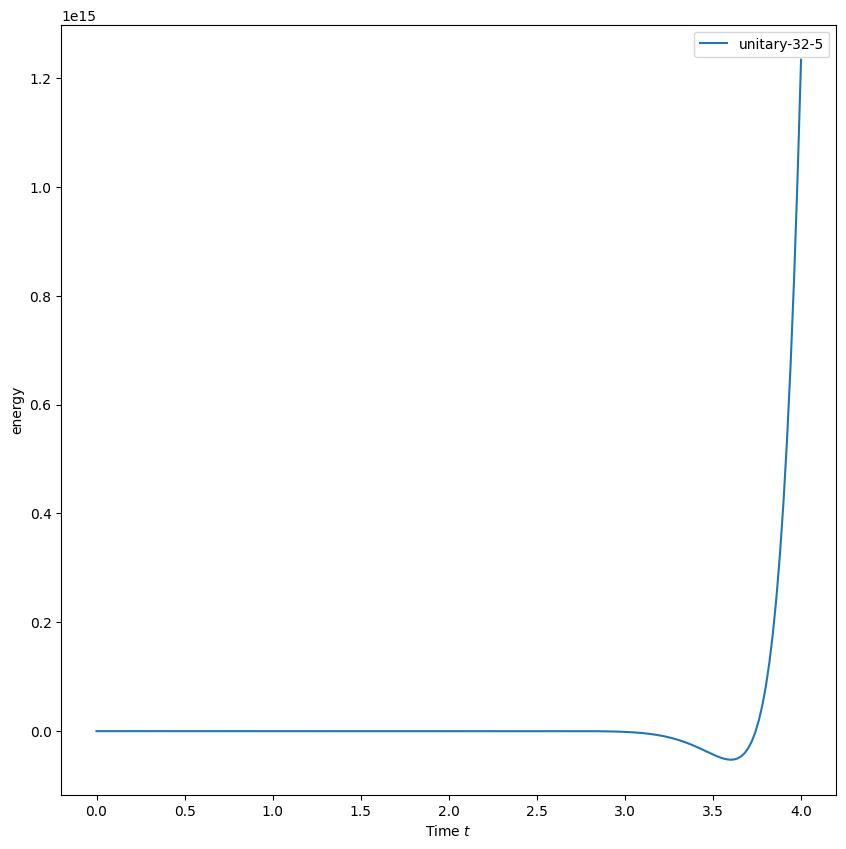

In [ ]:
import matplotlib.pyplot as plt

fig1, axs1 = plt.subplots(1, 1, sharex=True, figsize=(10,10))



axs1.plot(times, tdvp_results_ex1 , label='unitary-32-5')

axs1.set_xlabel("Time $t$")
axs1.set_ylabel("energy")  
axs1.legend()